In [1]:
# Data Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from custom_confusion_matrix import make_confusion_matrix
from scipy.stats import ks_2samp, kstest
# SMOTE
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore') 

In [2]:
dataframe = pd.read_excel("Taiwan/default of credit card clients.xls", header=1)

In [3]:
dataframe = dataframe.apply(pd.to_numeric)

In [4]:
dataframe.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
X = dataframe.drop(["default payment next month"], axis=1)
y = dataframe["default payment next month"]

In [6]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X, y)
print(np.bincount(y_over))

[23364 23364]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_over,
                                                    y_over,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_over,
                                                    shuffle=True)

In [8]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [9]:
numeric_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [10]:
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [11]:
X_train_transformed = full_processor.fit_transform(X_train)
X_test_transformed = full_processor.transform(X_test)

## Train Classifiers

In [12]:
svm_clf = SVC(random_state=42, probability=True)
lr_clf = LogisticRegression(random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
nb_clf = GaussianNB()
knn_clf = KNeighborsClassifier()
qda_clf = QuadraticDiscriminantAnalysis()
lda_clf = LinearDiscriminantAnalysis()
# ann_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(5, 2), random_state=1)

In [14]:
list_of_classifiers = [svm_clf, lr_clf, rf_clf, dt_clf, nb_clf, qda_clf, lda_clf, knn_clf]
name_of_classifiers = ["SVC", "LogisticRegression","RandomForestClassifier",
                       "DecisionTreeClassifier", "GaussianNB", "QuadraticDiscriminantAnalysis",
                       "LinearDiscriminantAnalysis", "KNeighborsClassifier"]

In [ ]:
results_mean = {}
results_std = {}
for classifier, name in zip(list_of_classifiers, name_of_classifiers):
    scores = cross_val_score(classifier, X_train_transformed, y_train)
    results_mean[name] = np.round(scores.mean(), decimals=2)
    results_std[name] = np.round(scores.std(), decimals=2)
    print(f"{name ann_clf} DONE!")

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(results_mean.keys(), results_mean.values(), yerr=results_std.values(), color="gray")
xlocs, xlabs = plt.xticks()
for i, v in enumerate(pd.Series(results_mean)):
    plt.text(xlocs[i], v - 0.05, str(v), ha = 'center', color="white")
plt.xticks(rotation=90)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Score")
plt.ylim(0.5, 0.9)
plt.tight_layout()
plt.show()

In [ ]:
auc_scores = []
ks = []
for classifier, name in zip(list_of_classifiers, name_of_classifiers):
    clf = classifier.fit(X_train_transformed, y_train)
    ks_score = kstest(y_test, clf.predict_proba(X_test_transformed)[:, 1])
    
    auc_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test_transformed)[:, 1]))
    ks.append(ks_score.statistic)

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(results_mean.keys(), auc_scores, color="lightcoral")
xlocs, xlabs = plt.xticks()
for i, v in enumerate(np.round(auc_scores, decimals=2)):
    plt.text(xlocs[i], v - 0.03, str(v), ha = 'center', color="white")
plt.xticks(rotation=90)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("AUC Score")
plt.ylim(0.5, 1)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(results_mean.keys(), ks, color="lightblue")
xlocs, xlabs = plt.xticks()
for i, v in enumerate(np.round(ks, decimals=3)):
    plt.text(xlocs[i], v - 0.03, str(v), ha = 'center', color="black")
plt.xticks(rotation=90)
plt.xlabel("Models")
plt.ylabel("KS Accuracy")
plt.title("KS Score")
plt.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict

from scipy.stats import spearmanr
from scipy.cluster import hierarchy

In [ ]:
feature_names = helper_cleaning.get_feature_names_mixture_column_transformer(
    full_processor,
    categorical_features,
    "number",
    "category")
importances = rf_clf.feature_importances_

In [ ]:
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False, inplace=True)
importance_mask = np.where(forest_importances > .07, 1, 0)

In [ ]:
color_important = ["lightcoral" if important == 1 else "gray" for important, value in zip(importance_mask, forest_importances)]

In [ ]:
plt.figure(figsize=(15, 8))
sns.barplot(x=forest_importances.index, y=forest_importances.values,
            palette=color_important)
plt.title("Feature importances using MDI")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
result = permutation_importance(
    rf_clf, X_train_transformed, y_train, n_repeats=10, random_state=42)

forest_importances_permutation = pd.Series(result.importances_mean, index=feature_names)
forest_importances_permutation.sort_values(ascending=False, inplace=True)

In [ ]:
permutation_importance_mask = np.where(forest_importances > .03, 1, 0)
color_important_permutation = ["lightcoral" if important == 1 else "gray" for important, value in zip(permutation_importance_mask, forest_importances)]

In [ ]:
plt.figure(figsize=(15, 8))
sns.barplot(x=forest_importances_permutation.index, y=forest_importances_permutation.values,
            palette=color_important_permutation)
plt.title("Feature importances using permutation on full model")
plt.ylabel("Mean accuracy decrease")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train_transformed).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [ ]:
cluster_ids = hierarchy.fcluster(corr_linkage, 2, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train_transformed[:, selected_features]
X_test_sel = X_test_transformed[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on Validation data with features removed: {:.2f} %".format(
      clf_sel.score(X_test_sel, y_test) * 100))

In [ ]:
print("Selected Features: {}".format(len(selected_features)))

In [ ]:
print("Original Features: {}".format(X_train_transformed.shape[1]))

# DT, ADA, RF

In [111]:
from mlxtend.classifier import StackingCVClassifier


svm_clf = SVC(random_state=42, probability=True)
knn_clf = KNeighborsClassifier(n_neighbors=5)
rf_clf = RandomForestClassifier(random_state=1)
ada_clf = AdaBoostClassifier(random_state=1)
dt_clf = DecisionTreeClassifier(random_state=1,
                              max_depth=None)

lr = LogisticRegression(random_state=1)

sclf_1 = StackingCVClassifier(classifiers=[dt_clf, ada_clf, rf_clf], 
                          meta_classifier=dt_clf, cv=10)


sclf_1.fit(X_train_sel, y_train)
print("Train Accuracy: %0.2f" % sclf_1.score(X_train_sel, y_train))
print("Test Accuracy: %0.2f" % sclf_1.score(X_test_sel, y_test))
dt_ada_rf_acc = sclf_1.score(X_test_sel, y_test)

Train Accuracy: 0.98
Test Accuracy: 0.84


# SVM, RF, DT

In [113]:
sclf_2 = StackingCVClassifier(classifiers=[svm_clf, rf_clf], 
                          meta_classifier=dt_clf, cv=10)


sclf_2.fit(X_train_sel, y_train)
print("Train Accuracy: %0.2f" % sclf_2.score(X_train_sel, y_train))
print("Test Accuracy: %0.2f" % sclf_2.score(X_test_sel, y_test))
svm_rf_dt = sclf_2.score(X_test_sel, y_test)

Train Accuracy: 0.98
Test Accuracy: 0.82


# LDA, QDA, ANN

In [115]:
sclf_3 = StackingCVClassifier(classifiers=[lda_clf, qda_clf], 
                          meta_classifier=ann_clf, cv=10)


sclf_3.fit(X_train_sel, y_train)
print("Train Accuracy: %0.2f" % sclf_3.score(X_train_sel, y_train))
print("Test Accuracy: %0.2f" % sclf_3.score(X_test_sel, y_test))
lda_qda_ann = sclf_3.score(X_test_sel, y_test)

Train Accuracy: 0.73
Test Accuracy: 0.70


In [116]:
stacking_classifiers = [sclf_1, sclf_2, sclf_3]
name_of_stacking = ["DT, ADA, RF", "SVM, RF, DT", "LDA, QDA, ANN"]
stacking_auc_scores = []
stacking_ks = []
for classifier, name in zip(stacking_classifiers, name_of_stacking):
    clf = classifier.fit(X_train_sel, y_train)
    ks_score = kstest(y_test, clf.predict_proba(X_test_sel)[:, 1])
    stacking_auc_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test_sel)[:, 1]))
    stacking_ks.append(ks_score.statistic)

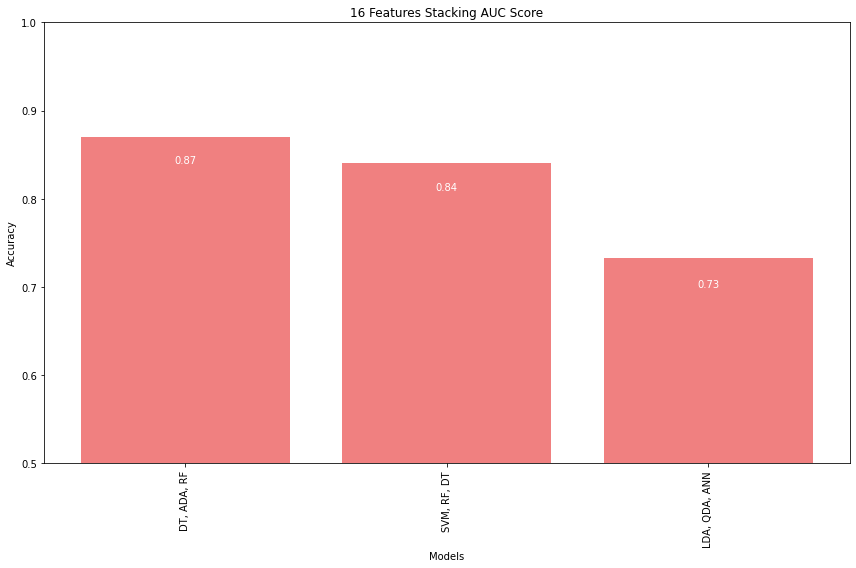

In [117]:
plt.figure(figsize=(12, 8))
plt.bar(name_of_stacking, stacking_auc_scores, color="lightcoral")
xlocs, xlabs = plt.xticks()
for i, v in enumerate(np.round(stacking_auc_scores, decimals=2)):
    plt.text(xlocs[i], v - 0.03, str(v), ha = 'center', color="white")
plt.xticks(rotation=90)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("16 Features Stacking AUC Score")
plt.ylim(0.5, 1)
plt.tight_layout()
plt.show()

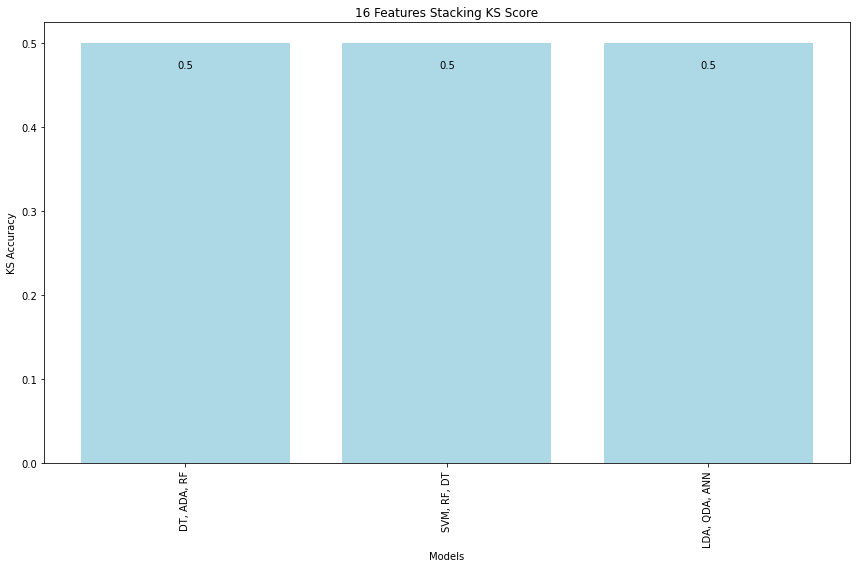

In [119]:
plt.figure(figsize=(12, 8))
plt.bar(name_of_stacking, stacking_ks, color="lightblue")
xlocs, xlabs = plt.xticks()
for i, v in enumerate(np.round(stacking_ks, decimals=4)):
    plt.text(xlocs[i], v - 0.03, str(v), ha = 'center', color="black")
plt.xticks(rotation=90)
plt.xlabel("Models")
plt.ylabel("KS Accuracy")
plt.title("16 Features Stacking KS Score")
plt.tight_layout()
plt.show()